In [2]:
# Data handling and plotting
import numpy as np
import pandas as pd 
import geopandas as gpd
import seaborn as sns 
import matplotlib.pyplot as plt
import pyproj
pyproj.datadir.set_data_dir("C:/Users/davha/anaconda3/envs/machine_learning_preprocessing/Library/share/proj")

# Import datasets 
1. aggregated dataset 
2. grid shapefile -> + transformation of GK-Zone splits into EPSG: 4236 
3. regions germany 

In [27]:
# Import dataset 
data = pd.read_csv('../datasets/ml_bwi_v2.csv') # new version2 without the differential features 

## Grid processing

In [28]:
grid = gpd.read_file('../datasets/ShapeFile_Tnr_INSPIRE_Poly1000/Tnr_INSPIRE_Poly1000.shp')

In [29]:
crs_grid = grid['EPSG'].unique()

In [30]:
regions = gpd.read_file('../datasets/de.json')

In [31]:
# Transformation of shapefile into the same crs as the grid

# Split shape fale based on crs 
splits = [grid[grid['EPSG'] == crs] for crs in crs_grid]

In [32]:
for i, split in enumerate(splits):
    split.iloc[:, 4] = split['Bl'].str.replace(';', '').str[0]
    split.to_crs(epsg=crs_grid[i], inplace=True)
    split.to_crs(epsg=4326, inplace=True)
    split.drop(columns=['EPSG'], inplace=True)
    splits[i] = split 

c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\davha\AppData\Local\Temp\ipykernel_13476\1412671616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  split.drop(columns=['EPSG'], inplace=True)
c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [33]:
grid_4326 = pd.concat(splits, ignore_index=True)

In [34]:
grid_4326.shape[0] == grid.shape[0]

True

In [35]:
# Export transformed grid data to datasets
grid_4326.to_file('../datasets/tnr_transformed_4326.geojson', driver='GeoJSON')

## Region json processing

In [37]:
# Adapt region naming in regions dataset 
county_dict = {
    "Schleswig-Holstein": 1,
    "Hamburg": 2,
    "Niedersachsen": 3,
    "Bremen": 4,
    "Nordrhein-Westfalen": 5,
    "Hessen": 6,
    "Rheinland-Pfalz": 7,
    "Baden-Württemberg": 8,
    "Bayern": 9,
    "Saarland": 10,
    "Berlin": 11,
    "Brandenburg": 12,
    "Mecklenburg-Vorpommern": 13,
    "Sachsen": 14,
    "Sachsen-Anhalt": 15,
    "Thüringen": 16
}

regions['name'] = regions['name'].replace(county_dict)


# Exploration of geographical distribution of features 
All aggregated to the regional level 

In [22]:
data.shape

(190273, 105)

In [23]:
data_cop = data.copy()

In [24]:
n_trees_per_region = data_cop['bl'].value_counts()

In [25]:
regions = regions.join(n_trees_per_region, on='name', rsuffix='_trees')

## Tree distribution before NaN and outlier removal 

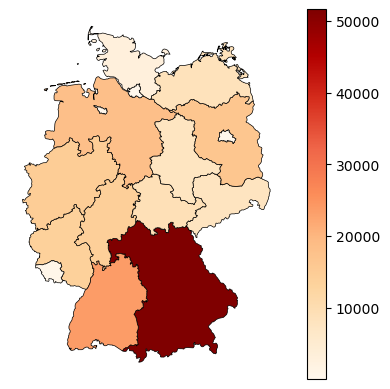

In [26]:
# Plotting the regions with a color map and improved outlines
ax = regions.plot(column='count',
                  legend=True,
                  cmap='OrRd',
                  edgecolor='black',
                  linewidth=0.5)

# Removing the axis and border
ax.set_axis_off()

# Adding title and legend
plt.show()


Problem here -> already highly clustered where there are a lot of trees -> we have an imbalance here already before filtering

In [18]:
# Filter dead trees 
data_cop = data[data['tot'] == 0]
data_cop.drop(columns=['tot'], inplace=True)

# Select the main species 
species = [10, 20, 30, 40, 50, 100, 110, 11, 140, 141, 200]

# Transform oak and maple species into one category
data_cop.loc[data_cop['Ba'].isin([110, 11]), 'Ba'] = 110
data_cop.loc[data_cop['Ba'].isin([140, 141]), 'Ba'] = 140

data_cop = data_cop[data_cop['Ba'].isin(species)]

C:\Users\davha\AppData\Local\Temp\ipykernel_23976\2368838278.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cop.drop(columns=['tot'], inplace=True)


In [19]:
data_cop.shape

(164693, 104)

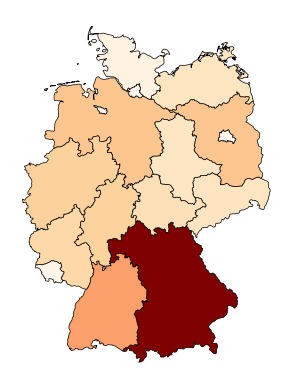

In [20]:
n_trees_per_region = data_cop['bl'].value_counts()
regions = regions.join(n_trees_per_region, on='name', rsuffix='_trees')

# Plotting the regions with a color map and improved outlines
ax = regions.plot(column='count_trees',
                  cmap='OrRd',
                  edgecolor='black',
                  linewidth=0.5)

# Removing the axis and border
ax.set_axis_off()

# Adding title and legend
plt.show()


In [21]:
def replace_custom_NA_with_NaN(df, no_data_value, filter_type='any'):
    if isinstance(no_data_value, list):
        for value in no_data_value:
            df.replace(value, np.nan, inplace=True)
    else:
        df.replace(no_data_value, np.nan, inplace=True)

# Filter rows that contain no data for any feature
replace_custom_NA_with_NaN(data_cop, no_data_value=[-9999, -1], filter_type='any')

In [22]:
def count_na_values(df, column):
    return df[column].isna().sum()

na_count = dict(zip(data_cop.columns, [count_na_values(data_cop, c) for c in data_cop.columns]))
na_count = pd.DataFrame(na_count.items(), columns=['Column', 'NA Count'])

In [23]:
na_features = na_count[na_count['NA Count'] > 0]
na_features.shape

(39, 2)

In [24]:
na_features

,Column,NA Count
9,D7,1350
19,Bhdst1,2
23,jSchael_x,162
26,Biov_o,162
27,Gexp,63404
28,GExpKl4,63430
29,GExpKl8,63404
30,Gform,4
34,potNatWg,4
40,NatNaeheHaupt,117


In [25]:
# Group by 'bl' and count NaNs
nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().sum())

C:\Users\davha\AppData\Local\Temp\ipykernel_23976\2599824471.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nan_counts_by_bl = data_cop.groupby('bl').apply(lambda x: x.isna().sum())


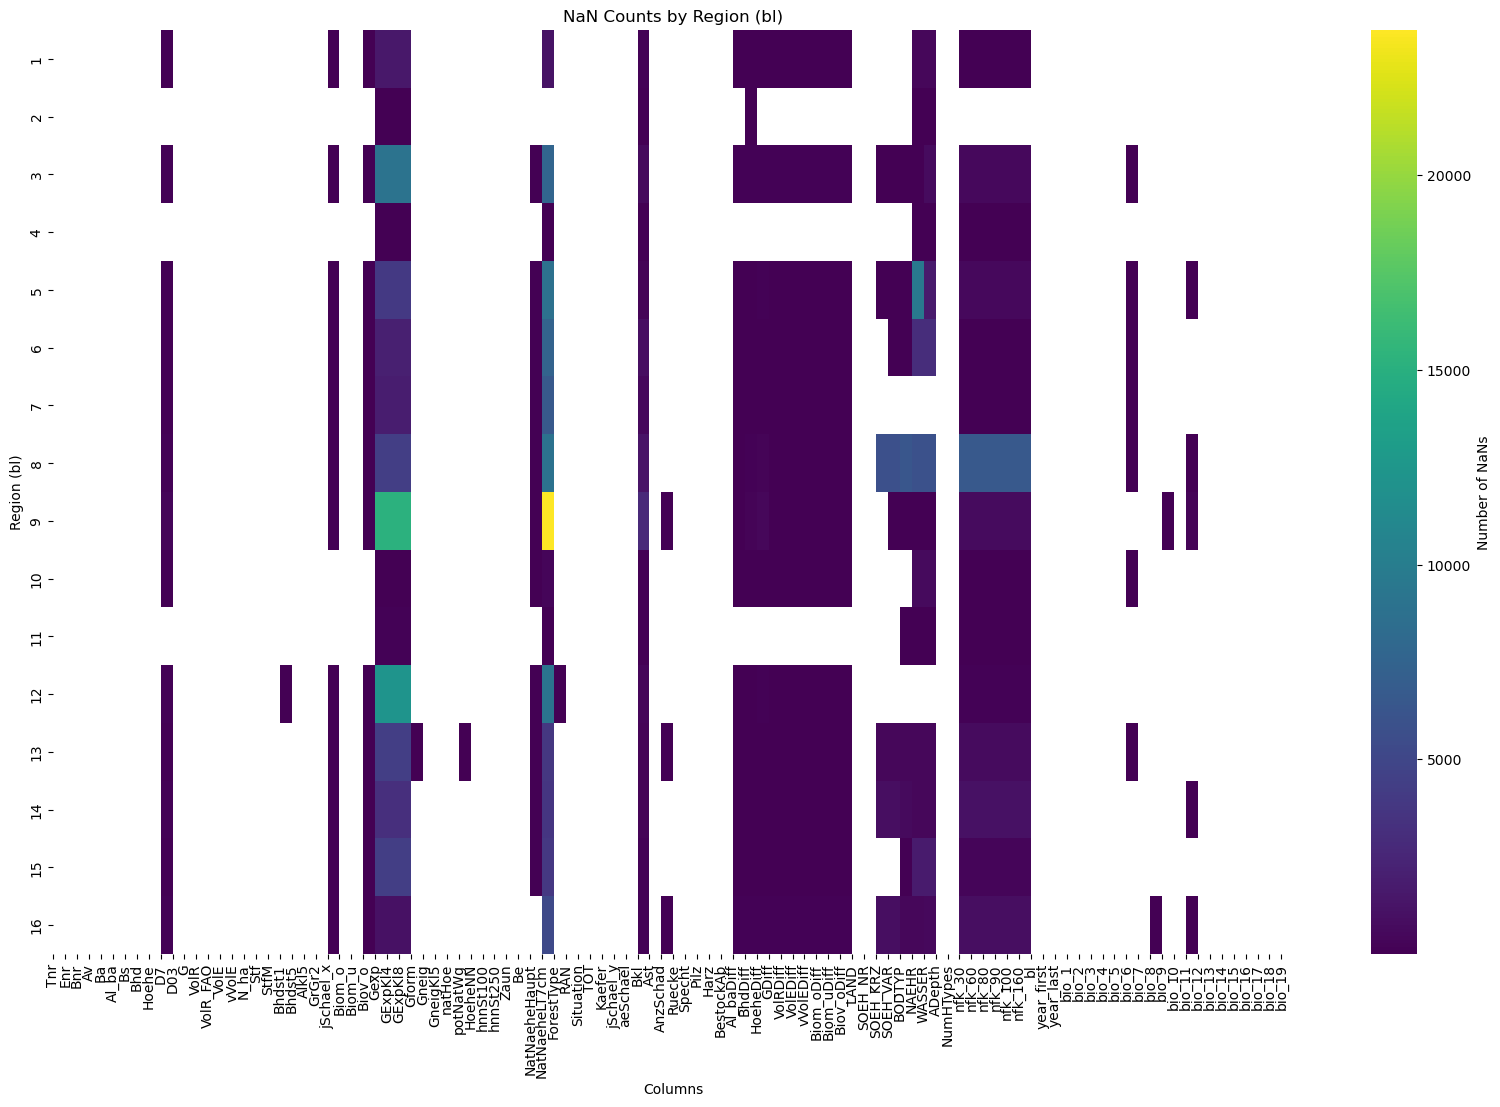

In [26]:
# Mask zero values
mask = nan_counts_by_bl == 0

# Create a heatmap
plt.figure(figsize=(20, 12))  # Increase the figure size for better visibility
ax = sns.heatmap(nan_counts_by_bl, cmap='viridis', cbar_kws={'label': 'Number of NaNs'}, mask=mask)
plt.title('NaN Counts by Region (bl)')
plt.xlabel('Columns')
plt.ylabel('Region (bl)')
plt.xticks(rotation=90)  # Rotate x-labels for better visibility

# Ensure the number of tick labels matches the number of ticks
ax.set_xticks(np.arange(len(nan_counts_by_bl.columns)))
ax.set_xticklabels(nan_counts_by_bl.columns, rotation=90)

plt.show()

In [27]:
nan_counts_by_bl['sum_nan'] = nan_counts_by_bl.sum(axis=1)
regions = regions.join(nan_counts_by_bl['sum_nan'], on='name', rsuffix='_sum_nans')

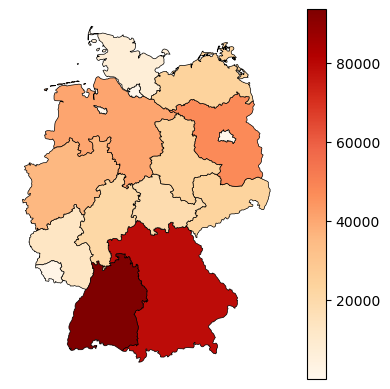

In [28]:
# Plotting the regions with a color map and improved outlines
ax = regions.plot(column='sum_nan',
                  legend=True,
                  cmap='OrRd',
                  edgecolor='black',
                  linewidth=0.5)

# Removing the axis and border
ax.set_axis_off()

# Adding title and legend
plt.show()

In [29]:
nan_feaures_to_drop = [
    'NatNaeheLT7cm',
]

In [30]:
data_cop.drop(columns=nan_feaures_to_drop, inplace=True)

In [31]:
test_nadrop = data_cop.dropna(how='any', inplace=False)

In [33]:
test_nadrop.shape

(78068, 103)

In [32]:
test_nadrop['Ba'].value_counts()

Ba
10     37294
100    16199
20     13885
30      2341
50      2182
110     1855
40      1769
200     1318
140     1225
Name: count, dtype: int64

In [33]:
test_nadrop.shape

(78068, 103)

In [189]:
test_nadrop.columns.to_list()

['Tnr',
 'Enr',
 'Bnr',
 'Av',
 'Ba',
 'Al_ba',
 'Bs',
 'Bhd',
 'Hoehe',
 'D7',
 'D03',
 'G',
 'VolR',
 'VolR_FAO',
 'VolE',
 'vVolE',
 'N_ha',
 'Stf',
 'StfM',
 'Bhdst1',
 'Bhdst5',
 'Alkl5',
 'GrGr2',
 'jSchael_x',
 'Biom_o',
 'Biom_u',
 'Biov_o',
 'Gexp',
 'GExpKl4',
 'GExpKl8',
 'Gform',
 'Gneig',
 'GneigKl5',
 'natHoe',
 'potNatWg',
 'HoeheNN',
 'hnnSt100',
 'hnnSt250',
 'Zaun',
 'Be',
 'NatNaeheHaupt',
 'ForestType',
 'RAN',
 'Situation',
 'TOT',
 'Kaefer',
 'jSchael_y',
 'aeSchael',
 'Bkl',
 'Ast',
 'AnzSchad',
 'Ruecke',
 'Specht',
 'Pilz',
 'Harz',
 'BestockAb',
 'Al_baDiff',
 'BhdDiff',
 'HoeheDiff',
 'GDiff',
 'VolRDiff',
 'VolEDiff',
 'vVolEDiff',
 'Biom_oDiff',
 'Biom_uDiff',
 'Biov_oDiff',
 'LAND',
 'SOEH_NR',
 'SOEH_KRZ',
 'SOEH_VAR',
 'BODTYP',
 'NAEHR',
 'WASSER',
 'ADepth',
 'NumHTypes',
 'nfk_30',
 'nfk_60',
 'nfk_80',
 'nfk_90',
 'nfk_100',
 'nfk_160',
 'bl',
 'year_first',
 'year_last',
 'bio_1',
 'bio_2',
 'bio_3',
 'bio_4',
 'bio_5',
 'bio_6',
 'bio_7',
 'bio_8',

In [43]:
select_these_cols = [
    'Tnr',
    'Enr',
    'Ba',
    'Al_ba',
    'Bhd',
    'Hoehe',
    'D7',
    'D03',
    'G',
    'VolR',
    'VolE',
    'vVolE',
    'N_ha',
    'Stf',
    'GrGr2',
    'Biom_o',
    'Biov_o',
    'Gexp',
    'Gform',
    'Gneig',
    'natHoe',
    'potNatWg',
    'HoeheNN',
    'Be',
    'NatNaeheHaupt',
    'Situation',
    'Bkl',
    'Ast',
    'BestockAb',
    'BODTYP',
    'NAEHR',
    'WASSER',
    'nfk_30',
    'bio_1',
    'bio_2',
    'bio_3',
    'bio_4',
    'bio_5',
    'bio_6',
    'bio_7',
    'bio_8',
    'bio_9',
    'bio_10',
    'bio_11',
    'bio_12',
    'bio_13',
    'bio_14',
    'bio_15',
    'bio_16',
    'bio_17',
    'bio_18',
    'bio_19'
    ]

In [44]:
test_nadrop[select_these_cols].columns

Index(['Tnr', 'Enr', 'Ba', 'Al_ba', 'Bhd', 'Hoehe', 'D7', 'D03', 'G', 'VolR',
       'VolE', 'vVolE', 'N_ha', 'Stf', 'GrGr2', 'Biom_o', 'Biov_o', 'Gexp',
       'Gform', 'Gneig', 'natHoe', 'potNatWg', 'HoeheNN', 'Be',
       'NatNaeheHaupt', 'Situation', 'Bkl', 'Ast', 'BestockAb', 'BODTYP',
       'NAEHR', 'WASSER', 'nfk_30', 'bio_1', 'bio_2', 'bio_3', 'bio_4',
       'bio_5', 'bio_6', 'bio_7', 'bio_8', 'bio_9', 'bio_10', 'bio_11',
       'bio_12', 'bio_13', 'bio_14', 'bio_15', 'bio_16', 'bio_17', 'bio_18',
       'bio_19'],
      dtype='object')

In [45]:
diff_features = ['Al_baDiff',
 'BhdDiff',
 'HoeheDiff',
 'GDiff',
 'VolRDiff',
 'VolEDiff',
 'vVolEDiff',
 'Biom_oDiff',
 'Biom_uDiff',
 'Biov_oDiff'
 ]

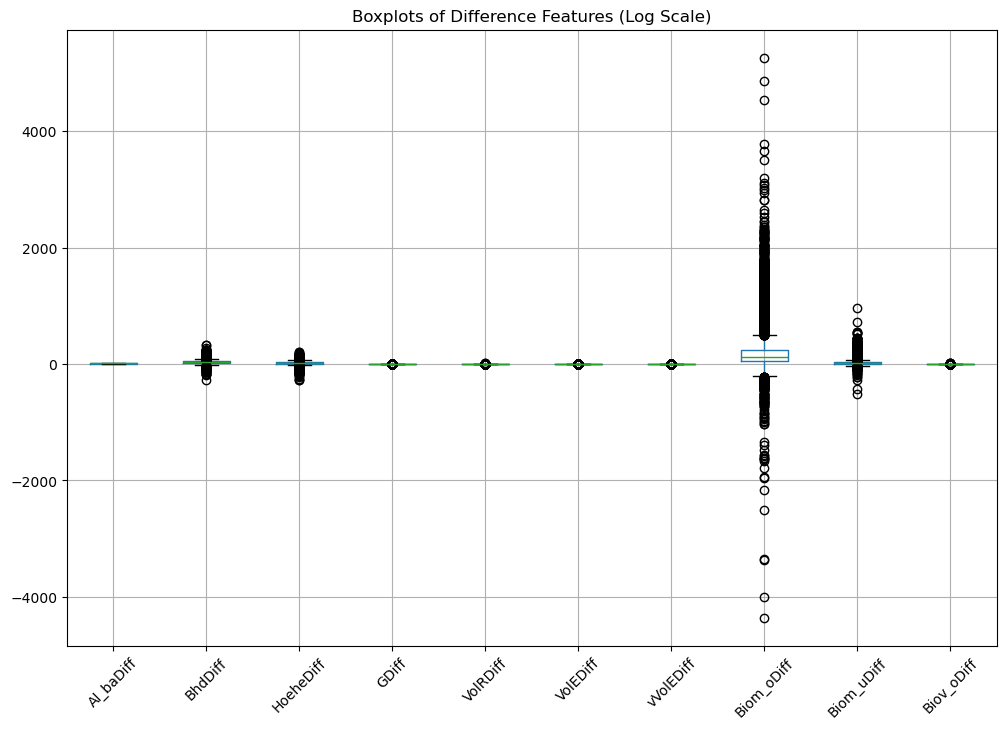

In [46]:
boxplot = test_nadrop[diff_features].boxplot(figsize=(12, 8))
plt.xticks(rotation=45)
plt.title('Boxplots of Difference Features (Log Scale)')
plt.show()

Negative values in the difference which I cannot full explain by reading the supplementary material. Since the focus is on classification and not prediction of growth (changes) I will omit these features.

In [47]:
sel_features = [
    'Tnr',
    'Enr',
    'Bnr',
    'Av',
    'Ba',
    'Al_ba',
    'Bs',
    'Bhd',
    'Hoehe',
    'D7',
    'D03',
    'G',
    'VolR',
    'VolE',
    'vVolE',
    'N_ha',
    'Stf',
    'StfM',
    'Bhdst1',
    'Bhdst5',
    'Alkl5',
    'GrGr2',
    'jSchael_x',
    'Biom_o',
    'Biom_u',
    'Biov_o',
    'Gexp',
    'Gform',
    'Gneig',
    'natHoe',
    'potNatWg',
    'HoeheNN',
    'Zaun',
    'Be',
    'NatNaeheHaupt',
    'ForestType',
    'RAN',
    'Situation',
    'TOT',
    'Kaefer',
    'aeSchael',
    'Bkl',
    'Ast',
    'AnzSchad',
    'Ruecke',
    'Specht',
    'Pilz',
    'Harz',
    'BestockAb',
    'BODTYP',
    'NAEHR',
    'WASSER',
    'ADepth',
    'NumHTypes',
    'nfk_30',
    'bl',
    'bio_1',
    'bio_2',
    'bio_3',
    'bio_4',
    'bio_5',
    'bio_6',
    'bio_7',
    'bio_8',
    'bio_9',
    'bio_10',
    'bio_11',
    'bio_12',
    'bio_13',
    'bio_14',
    'bio_15',
    'bio_16',
    'bio_17',
    'bio_18',
    'bio_19'
    ]

In [48]:
test_nadrop = test_nadrop[sel_features]

In [49]:
test_nadrop.shape

(78068, 75)

In [50]:
# Get columns where any value is less than 0
numeric_cols = test_nadrop.select_dtypes(include=[np.number])
features_with_negative_values = numeric_cols.columns[(numeric_cols < 0).any()].tolist()
features_with_negative_values

['ADepth', 'bio_6', 'bio_8', 'bio_9', 'bio_11']

In [51]:
test_nadrop = test_nadrop[test_nadrop['ADepth'] > 0]

In [52]:
test_nadrop.shape

(69580, 75)

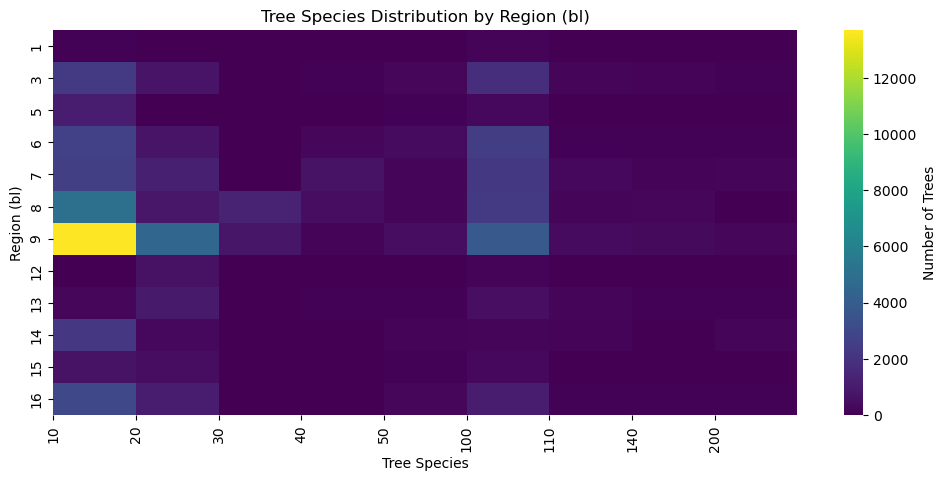

In [53]:
species_per_bl = test_nadrop.groupby('bl')['Ba'].value_counts().unstack().fillna(0)
species_per_bl

plt.figure(figsize=(12, 5)) 
ax = sns.heatmap(species_per_bl, cmap='viridis', cbar_kws={'label': 'Number of Trees'})
plt.title('Tree Species Distribution by Region (bl)')
plt.xlabel('Tree Species')
plt.ylabel('Region (bl)')
plt.xticks(rotation=90)  

ax.set_xticks(np.arange(len(species_per_bl.columns)))
ax.set_xticklabels(species_per_bl.columns, rotation=90)

plt.show()

In [59]:
species_per_bl_per = species_per_bl.div(species_per_bl.sum(axis=0), axis=1) * 100
species_per_bl_per

Ba,10,20,30,40,50,100,110,140,200
bl,,,,,,,,,
1,0.263111,0.035088,0.000000,0.059952,0.198906,0.719472,3.006135,0.865052,0.482625
3,6.921605,6.464912,0.000000,5.095923,11.188463,11.927393,11.104294,9.515571,7.142857
5,3.250015,0.385965,0.000000,0.959233,3.033317,2.099010,2.453988,1.903114,3.957529
6,7.713927,6.228070,0.000000,13.968825,20.686226,16.026403,6.012270,7.179931,5.888031
7,7.630210,10.692982,1.152184,40.587530,9.348583,14.627063,18.527607,11.072664,15.637066
8,15.015248,7.219298,62.121940,25.779376,8.204873,15.287129,10.122699,20.328720,1.930502
9,40.952580,39.114035,36.341815,7.973621,23.073098,24.990099,23.680982,30.449827,24.227799
12,0.080727,5.578947,0.000000,0.299760,0.198906,0.785479,2.024540,1.038062,1.737452
13,0.741494,8.421053,0.000000,4.136691,3.729488,3.221122,10.306748,6.660900,8.397683


In [60]:
regions = regions.join(species_per_bl_per, on='name', rsuffix='species_perc').fillna(0)

C:\Users\davha\AppData\Local\Temp\ipykernel_23976\126198509.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar


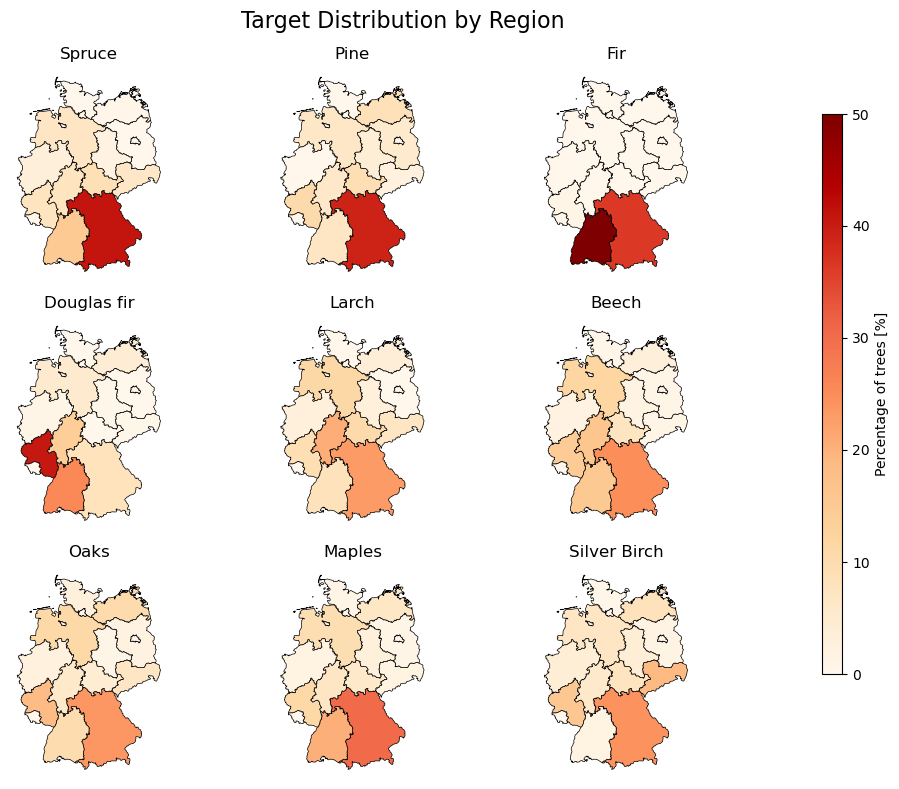

In [62]:
# Define the column names and columns to plot
column_names = {
    10: 'Spruce',
    20: 'Pine',
    30: 'Fir',
    40: 'Douglas fir',
    50: 'Larch',
    100: 'Beech',
    110: 'Oaks',
    140: 'Maples',
    200: 'Silver Birch'
}

columns_to_plot = [10, 20, 30, 40, 50, 100, 110, 140, 200]

# Create a figure and axes for the facet wrap with shared axis
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 8), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column in a separate subplot with shared colors
for i, column in enumerate(columns_to_plot):
    ax = regions.plot(column=column,
                      legend=False,  # Disable individual legends
                      cmap='OrRd',
                      edgecolor='black',
                      linewidth=0.5,
                      ax=axes[i],
                      vmin=0, vmax=50)  # Set the same color scale for all subplots
    ax.set_title(column_names[column])
    ax.set_axis_off()

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of the colorbar
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=50))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Percentage of trees [%]')
fig.suptitle('Target Distribution by Region', fontsize=16)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to make space for colorbar
plt.show()

-> Do not use the BL, Tnr, Enr as feature but use Tnr as groups for GroupStratifiedKFolds 


In [63]:
test_nadrop.columns.to_list()

['Tnr',
 'Enr',
 'Bnr',
 'Av',
 'Ba',
 'Al_ba',
 'Bs',
 'Bhd',
 'Hoehe',
 'D7',
 'D03',
 'G',
 'VolR',
 'VolE',
 'vVolE',
 'N_ha',
 'Stf',
 'StfM',
 'Bhdst1',
 'Bhdst5',
 'Alkl5',
 'GrGr2',
 'jSchael_x',
 'Biom_o',
 'Biom_u',
 'Biov_o',
 'Gexp',
 'Gform',
 'Gneig',
 'natHoe',
 'potNatWg',
 'HoeheNN',
 'Zaun',
 'Be',
 'NatNaeheHaupt',
 'ForestType',
 'RAN',
 'Situation',
 'TOT',
 'Kaefer',
 'aeSchael',
 'Bkl',
 'Ast',
 'AnzSchad',
 'Ruecke',
 'Specht',
 'Pilz',
 'Harz',
 'BestockAb',
 'BODTYP',
 'NAEHR',
 'WASSER',
 'ADepth',
 'NumHTypes',
 'nfk_30',
 'bl',
 'bio_1',
 'bio_2',
 'bio_3',
 'bio_4',
 'bio_5',
 'bio_6',
 'bio_7',
 'bio_8',
 'bio_9',
 'bio_10',
 'bio_11',
 'bio_12',
 'bio_13',
 'bio_14',
 'bio_15',
 'bio_16',
 'bio_17',
 'bio_18',
 'bio_19']

In [65]:
import re
# Change soil type column to reduce number of categories
test_nadrop['BODTYP'] = test_nadrop['BODTYP'].apply(lambda x: re.findall(r'[A-Z]+', x))
test_nadrop['BODTYP'] = test_nadrop['BODTYP'].apply(lambda x: x[0][0] if x else None)

In [66]:
# Change water column to reduce number of categories
test_nadrop["WASSER"].value_counts()
test_nadrop['WASSER'] = test_nadrop['WASSER'].apply(lambda x: re.split('[-/]', x)[0] if '-' in x or '/' in x else x)


In [72]:
test_final = test_nadrop[select_these_cols]
test_final.shape

(69580, 52)

In [75]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69580 entries, 0 to 190272
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tnr            69580 non-null  int64  
 1   Enr            69580 non-null  int64  
 2   Ba             69580 non-null  int64  
 3   Al_ba          69580 non-null  float64
 4   Bhd            69580 non-null  int64  
 5   Hoehe          69580 non-null  float64
 6   D7             69580 non-null  float64
 7   D03            69580 non-null  float64
 8   G              69580 non-null  float64
 9   VolR           69580 non-null  float64
 10  VolE           69580 non-null  float64
 11  vVolE          69580 non-null  float64
 12  N_ha           69580 non-null  float64
 13  Stf            69580 non-null  float64
 14  GrGr2          69580 non-null  int64  
 15  Biom_o         69580 non-null  float64
 16  Biov_o         69580 non-null  float64
 17  Gexp           69580 non-null  float64
 18  Gform     

In [77]:
numerical_cols = [
    'Al_ba',
    'Bhd',
    'Hoehe',
    'D7',
    'D03',
    'G',
    'VolR',
    'VolE',
    'vVolE',
    'N_ha',
    'Stf',
    'Biom_o',
    'Biov_o',
    'Gexp',
    'HoeheNN',
    'nfk_30',
    'bio_1',
    'bio_2',
    'bio_3',
    'bio_4',
    'bio_5',
    'bio_6',
    'bio_7',
    'bio_8',
    'bio_9',
    'bio_10',
    'bio_11',
    'bio_12',
    'bio_13',   
    'bio_14',
    'bio_15',
    'bio_16',
    'bio_17',
    'bio_18',
    'bio_19'
]

In [78]:
test_final[numerical_cols].describe()

,Al_ba,Bhd,Hoehe,D7,D03,G,VolR,VolE,vVolE,N_ha,...,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19
count,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,...,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000,69580.000000
mean,80.512662,347.531446,251.575697,275.088977,272.704858,0.111170,1.475466,1.196078,1.121114,81.434545,...,16.195450,0.303564,985.735456,118.102343,55.796766,0.221727,308.450762,194.838287,285.004714,235.048548
std,37.872002,144.111443,69.056386,122.499015,111.217970,0.093969,1.573276,1.318992,1.243086,106.189429,...,1.273989,1.168478,350.035680,46.022446,19.109422,0.062121,120.668204,68.890513,116.743240,91.609856
min,9.000000,70.000000,70.000000,0.000000,51.000000,0.003848,0.005248,0.002627,0.002627,0.000000,...,10.520000,-4.020000,482.000000,51.000000,26.000000,0.090000,144.000000,91.000000,136.000000,91.000000
25%,49.000000,243.000000,204.000000,188.000000,193.000000,0.046377,0.453109,0.355439,0.324546,28.064087,...,15.480000,-0.400000,761.000000,91.000000,43.000000,0.180000,233.000000,148.000000,216.000000,169.000000
50%,77.000000,333.000000,254.000000,265.000000,261.000000,0.087092,1.011150,0.798640,0.746129,47.052025,...,16.410000,0.350000,883.000000,106.000000,51.000000,0.210000,275.000000,178.000000,254.000000,211.000000
75%,105.000000,434.000000,301.000000,350.000000,337.000000,0.147934,1.944544,1.568222,1.476541,87.687164,...,17.100000,1.150000,1086.000000,129.000000,64.000000,0.260000,336.000000,219.000000,305.000000,279.000000
max,314.000000,1570.000000,525.000000,1237.000000,1235.000000,1.935928,23.212921,20.770138,19.434792,1194.253540,...,19.690000,3.840000,3252.000000,388.000000,202.000000,0.490000,1027.000000,704.000000,1027.000000,710.000000


In [79]:
corr_mat = test_final[numerical_cols].corr().stack().reset_index(name="correlation")

<Axes: xlabel='level_1', ylabel='level_0'>

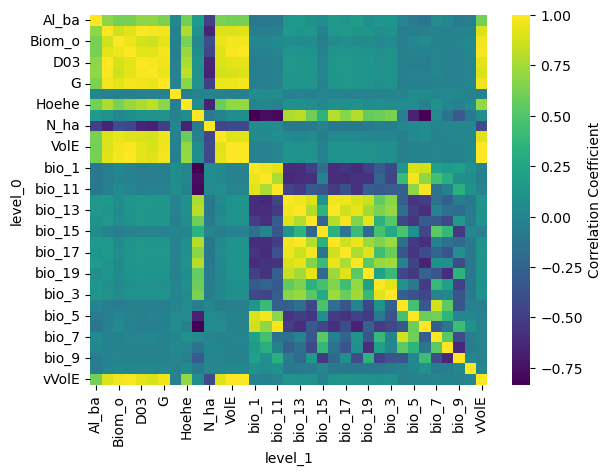

In [82]:
# Pivot the correlation matrix to create a matrix format
corr_matrix_pivot = corr_mat.pivot(index='level_0', columns='level_1', values='correlation')

# Plot the heatmap
sns.heatmap(corr_matrix_pivot, cmap='viridis', cbar_kws={'label': 'Correlation Coefficient'})


In [104]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(test_final[numerical_cols])

# Apply PCA
pca = PCA(n_components=35)  # You can change the number of components
principal_components = pca.fit_transform(scaled_features)

In [105]:
print(f"Explained variance ratios for 10 components: {pca.explained_variance_ratio_}")

Explained variance ratios for 10 components: [3.31064206e-01 2.70831817e-01 1.27434003e-01 6.38691266e-02
 3.62534742e-02 3.03671739e-02 2.92301303e-02 2.75922803e-02
 1.78245766e-02 1.62084294e-02 1.32256505e-02 9.32514308e-03
 7.48347656e-03 4.29756863e-03 3.75952145e-03 2.76328279e-03
 2.14023968e-03 1.54572375e-03 1.20270110e-03 1.00848856e-03
 8.56244784e-04 4.30130088e-04 3.40389984e-04 2.80507818e-04
 1.78084144e-04 1.49656547e-04 1.13311493e-04 8.38553993e-05
 4.95935651e-05 4.44350778e-05 2.18392720e-05 1.54603917e-05
 5.68914673e-06 3.78893984e-06 0.00000000e+00]


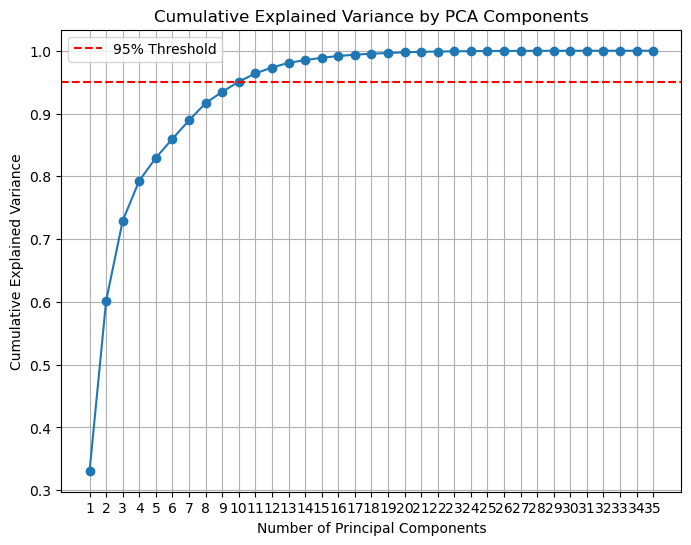

In [106]:

exp_var = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(exp_var)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid()
plt.legend()
plt.show()

In [99]:
components = pca.components_

In [100]:
components

array([[ 1.85289053e-01,  2.38718131e-01,  1.86018586e-01,
         2.36827930e-01,  2.40595159e-01,  2.37372484e-01,
         2.32392786e-01,  2.31333790e-01,  2.32088314e-01,
        -1.46064691e-01,  2.08551165e-01,  2.16731584e-01,
         2.33314535e-01, -1.42892550e-02,  1.69474441e-01,
        -1.44829248e-02, -1.43213498e-01,  1.20854384e-01,
         1.43668980e-01, -5.09614064e-02, -1.28448591e-01,
        -1.27422776e-01, -2.54211305e-02, -4.33269713e-02,
        -3.78185581e-02, -1.46265916e-01, -1.18201550e-01,
         1.88292534e-01,  1.83067090e-01,  1.64032594e-01,
         3.12268789e-02,  1.84582682e-01,  1.77660555e-01,
         1.77059197e-01,  1.50859972e-01],
       [-1.08960704e-01, -1.73167795e-01, -1.50531583e-01,
        -1.75123593e-01, -1.72576934e-01, -1.76867516e-01,
        -1.84375950e-01, -1.82662458e-01, -1.80533741e-01,
         9.94443392e-02, -1.97902609e-01, -1.91980125e-01,
        -1.81747991e-01, -3.40849446e-03,  2.27051891e-01,
        -3.11

In [1]:
test_final.columbs.to_list()

NameError: name 'test_final' is not defined